# base code

In [1]:
%matplotlib inline
import numpy, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import ee; ee.Initialize()
bandStack = lambda a, b: ee.Image(b).addBands(a)
get_value = lambda df, field: [feature['properties'][field] for feature in df]
def rename_bands(img):
    img = ee.Image(img)
    names = img.bandNames()
    prefix = ee.String(img.get("system:index")).cat("_")
    new_names = names.map(lambda b: prefix.cat(b))
    return img.select(names, new_names)
def load_dataset(oname, gee_func, update=False):
    if update:
        print('fetch from GEE....', end="")
        df = gee_func()        
        df.to_pickle(oname) # df.to_csv(oname)
        print('save to: ' + oname)
    else:
        print('load from local: ' + oname)
        df = pd.read_pickle(oname) # df.to_csv(oname+'.csv')
#         df = pd.read_csv(oname+'.csv', index_col=0)
    return df
# snippet to calculate time series
def getv(reduce, field, index): # get as field
    fc = reduce.getInfo()['features']
    value = [feature['properties'][field] for feature in fc]
    index = [feature['properties'][index] for feature in fc]    
    df = pd.DataFrame(get_value(fc, 'sum'), index=get_value(fc, 'country'))
    df = df.sort_index()
    return df
def gets(reduce, field, date=None): # get as timeseries
    fc = reduce.getInfo()['features']    
    columns = [df['properties']['name'] for df in fc]
    keys = sorted(fc[0]['properties'].keys())http://192.168.99.100:32768/notebooks/work/Time%20Series.ipynb#
    keys = [k for k in keys if not k.find(field) == -1]
    value = [[df['properties'][k] for df in fc] for k in keys]
    if date == None:
        if field == 'NDVI':
#             date = [k.split('005_')[1] for k in keys if not k.find(field) == -1]        
            date = [k.lstrip('MYD13Q1_005_').rstrip('_NDVI').replace('_','') for k in keys if not k.find(field) == -1]        
        else:
            date = [k.split('_')[0] for k in keys if not k.find(field) == -1]        
    else:
        pass
#     if field == 'NDVI':
#         print(date)
#     else:
    df = pd.DataFrame(value, columns=columns, index=pd.to_datetime(date, format="%Y%m%d"))
    return df
continent = ee.FeatureCollection('ft:1fM786Wbri6CqIz3JvyQ_vvMIBGbdUmTOGacZTnb-') # africa continent
aezs8 = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt') # africa AEZs
countries = ee.FeatureCollection('ft:1fGODObRcgWotUauiKV_2GlM7ZXX0sdZ5FLTJeALZ') # africa Countries
print('loaded')

loaded


# examples
## monthly CHIRPS data frame by zones

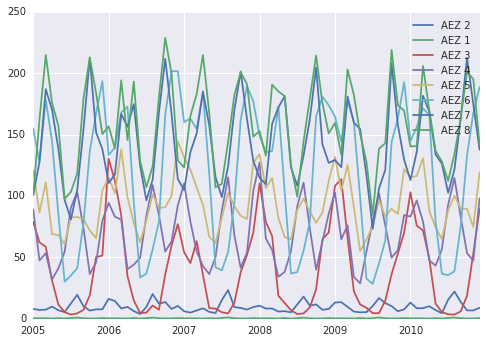

In [2]:
# get monthly precipitation from chirps
start='2005-1-01'; end='2010-12-31'; nbands=72*12
bandlist = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation') \
.filterDate(start, end).sort('system:index', True) \
.toList(nbands).map(rename_bands)

bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0))) # image stack
df_prcp_5day = gets(bands.reduceRegions(aezs8, ee.Reducer.mean(), 50000), 'precipitation') # retrieve reduceRegions as pandas dataframe
df_prcp_mon = df_prcp_5day.resample('M', how=sum)
df_prcp_mon.plot()
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## annual CHIRPS data frame by zones

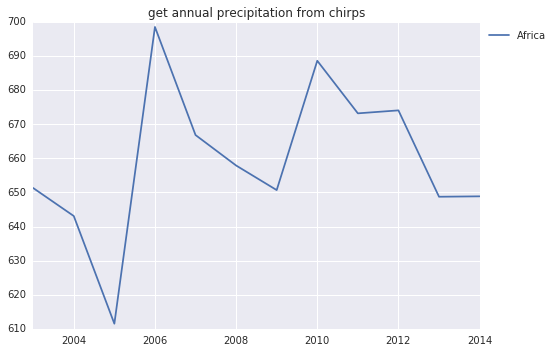

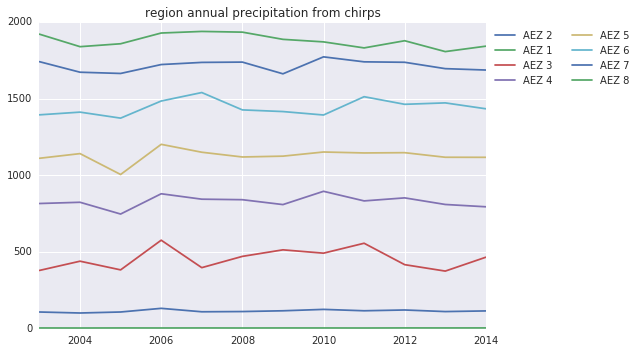

In [8]:
# get annual precipitation from chirps
start='2003-01-01'; end='2014-12-31'; nbands=72*12
bandlist = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation') \
.filterDate(start, end).sort('system:index', True) \
.toList(nbands).map(rename_bands)

bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
df_prcp = gets(bands.reduceRegions(continent, ee.Reducer.mean(), 50000), 'precipitation')
df_prcp = df_prcp.resample('A', how=sum)
df_prcp.plot(title='get annual precipitation from chirps')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)

df_prcp_re = gets(bands.reduceRegions(aezs8, ee.Reducer.mean(), 50000), 'precipitation')
df_prcp_re = df_prcp_re.resample('A', how=sum)
df_prcp_re.plot(title='region annual precipitation from chirps')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)

## get NDVI time-series from MYD13Q1


In [4]:
start='2005-01-01'; end='2010-12-31'; nbands=23*6
bandlist = ee.ImageCollection('MODIS/MYD13Q1').select('NDVI') \
.filterDate(start, end).sort('system:index', True) \
.toList(nbands).map(rename_bands)
bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
df_ndvi = gets(bands.reduceRegions(aezs8, ee.Reducer.mean(), 2000), 'NDVI')

## 16-day MODIS NDVI series with prcp series

(1, 12)

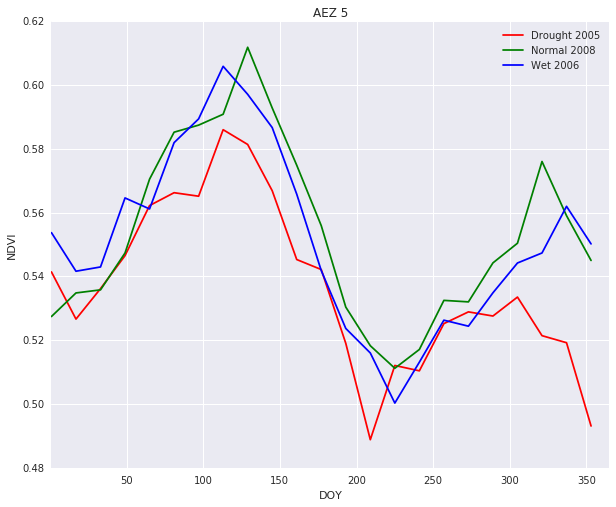

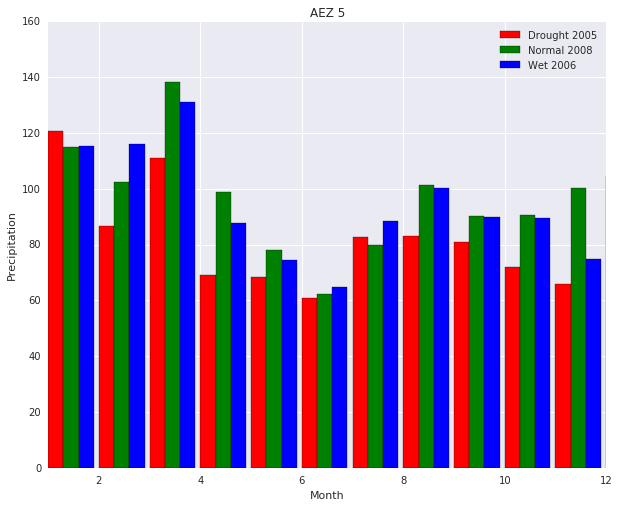

In [5]:
zone='AEZ 5'
d2005=df_ndvi[zone][:23]
d2008=df_ndvi[zone][23*1:23*1+23]
d2010=df_ndvi[zone][-23:]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(numpy.arange(1,365,16), d2005/1e4, color = 'red', label='Drought 2005')
ax.plot(numpy.arange(1,365,16), d2008/1e4, color = 'green', label='Normal 2008')
ax.plot(numpy.arange(1,365,16), d2010/1e4, color = 'blue', label='Wet 2006')
ax.legend()
ax.set_title(zone)
ax.set_xlabel('DOY')
ax.set_ylabel('NDVI')
ax.set_xlim(1,365)

p2005=df_prcp_mon[zone][:12]
p2008=df_prcp_mon[zone][12*1:12*1+12]
p2010=df_prcp_mon[zone][-12:]

fig, ax1 = plt.subplots(figsize=(10,8))
ind = numpy.arange(1,13,1)
width = 0.3
ax1.bar(ind, p2005, width, color = 'red', label='Drought 2005')
ax1.bar(ind + width, p2008, width, color = 'green', label='Normal 2008')
ax1.bar(ind + width + width, p2010, width, color = 'blue', label='Wet 2006')

ax1.legend()
ax1.set_title(zone)
ax1.set_xlabel('Month')
ax1.set_ylabel('Precipitation')
ax1.set_xlim(1,12)


In [ ]:
pd.concat([df_prcp_re[title], df_net[title]], axis=1, join_axes=[df_prcp_re[title].index]).plot(legend=False)

In [ ]:
df_net.columns = [x + ' Net Cropland' for x in df_net.columns]
df_prcp_re.columns = [x + ' Precip' for x in df_prcp_re.columns]


In [ ]:
# df_net.sorted
df_net = df_net.sort(axis=1)
df_prcp_re = df_prcp_re.sort(axis=1)
full_df = pd.concat([df_prcp_re, df_net], axis=1, join_axes=[df_prcp_re.index])
full_df.index = [x.year for x in full_df.index]
# full_df

## get annual cropland from GCPA

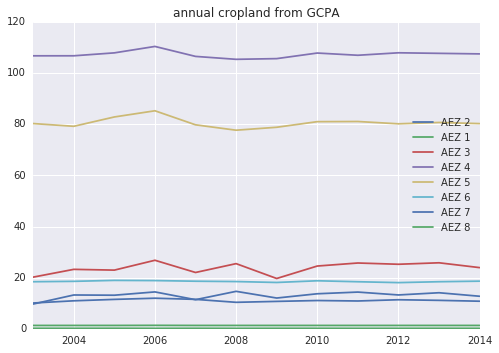

In [11]:
mha = ee.Image.pixelArea().multiply(1e-10)
def fetch_band(img):
    img = ee.Image(img)
    mask = img.gt(0).And(img.lt(9))
    return mask.select([0], ['crop']).multiply(mha)

bandlist = ee.ImageCollection('users/JunXiong1981/GCPA250mv3').sort('index', True).toList(12).map(fetch_band)
bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
rd = bands.reduceRegions(aezs8, ee.Reducer.sum(), 2330)
date = ['%d1231' % d for d in range(2003, 2015)]
df_net = gets(rd, 'crop', date=date) * 1.14
df_net.plot(title='annual cropland from GCPA')

## linear relationship between net cropland area and precipitation

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(....) is deprecated, use sort_index(.....)


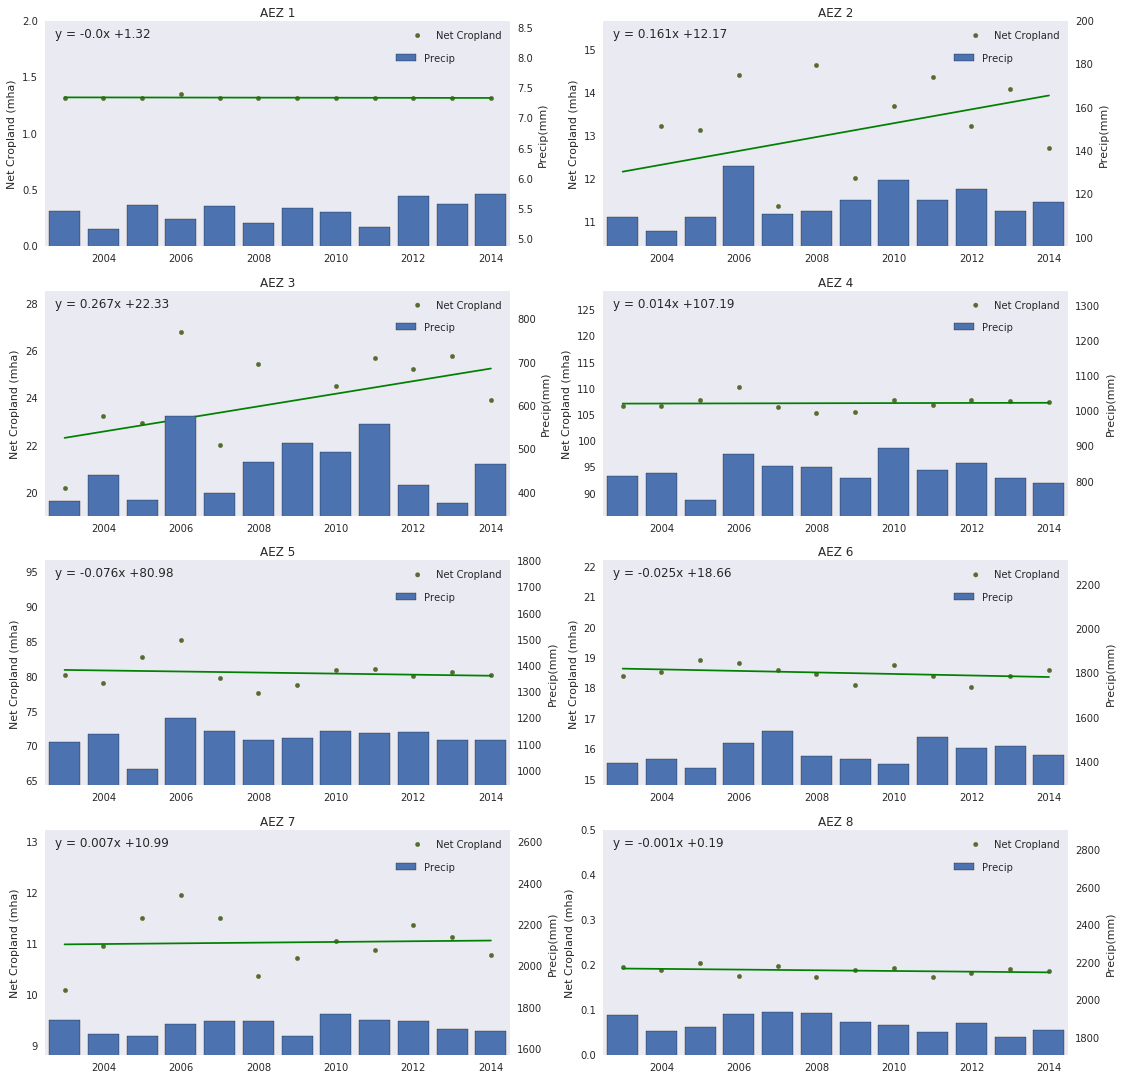

In [13]:
df_net.columns = [x + ' Net Cropland' for x in df_net.columns]
df_prcp_re.columns = [x + ' Precip' for x in df_prcp_re.columns]
# df_net.sorted
df_net = df_net.sort(axis=1)
df_prcp_re = df_prcp_re.sort(axis=1)
full_df = pd.concat([df_prcp_re, df_net], axis=1, join_axes=[df_prcp_re.index])
full_df.index = [x.year for x in full_df.index]

import seaborn as sns
fig, axs = plt.subplots(4,2, figsize=(15, 15), facecolor='w', edgecolor='k')
plt.tight_layout()
fig.subplots_adjust(hspace=.2, wspace=0.2)
count = 1
for j in range(4):
    for k in range (2):
        y1 = 'AEZ ' + str(count) + ' Net Cropland'
        y2 = 'AEZ ' + str(count) + ' Precip'  
        axs[j,k].scatter(full_df.index, full_df[y1], color = 'darkolivegreen', label = 'Net Cropland')
        axs[j,k].grid(False)
        axs[j,k].set_ylabel('Net Cropland (mha)')

#         ymax = full_df[y1].max() + .05*full_df[y1].max()
        ymax = full_df[y1].mean() + 0.2*full_df[y1].mean()
        ymin = full_df[y1].mean() - 0.2*full_df[y1].mean()
#         ymax = ymin + 10
        axs[j,k].set_xlim([2002.5, 2014.5])
        if count == 1:
            axs[j,k].set_ylim([0, 2])
        elif count == 8:
            axs[j,k].set_ylim([0, 0.5])
        else:
            axs[j,k].set_ylim([ymin, ymax])
        
#         x = full_df.index.values
        x = numpy.arange(12)
        y = full_df[y1].values
        fit = numpy.polyfit(x,y,1)
        fit_fn = numpy.poly1d(fit) 
        axs[j,k].plot(full_df.index.values, fit_fn(x), color = 'green')
        axs[j,k].legend(loc=1)
        
        ax2 = axs[j,k].twinx()
        ax2.bar(full_df.index, full_df[y2], label = 'Precip', align='center')
        ax2.set_ylabel('Precip(mm)')
        ax2.set_title('AEZ ' + str(count))
        ax2.grid(False)

        ymax = full_df[y2].max() + .5*full_df[y2].max()
        ymin = full_df[y2].min() - .05*full_df[y2].max()
        ax2.set_xlim([2002.5, 2014.5])
        ax2.set_ylim([ymin,ymax])
        ax2.legend(bbox_to_anchor=(0.9,0.9))        
#         sign = round(fit_fn[0]>0?'+':'-'
        sign = '+' if fit_fn[0]>0 else '-'
        plt.annotate('y = ' + str(round(fit_fn[1], 3)) + 'x ' + sign + str(abs(round(fit_fn[0], 2))), xy=(0.02, 0.93), xycoords='axes fraction')
        count += 1
plt.savefig('output.png', dpi = 300)

Index(['AEZ 1 Net Cropland', 'AEZ 2 Net Cropland', 'AEZ 3 Net Cropland',
       'AEZ 4 Net Cropland', 'AEZ 5 Net Cropland', 'AEZ 6 Net Cropland',
       'AEZ 7 Net Cropland', 'AEZ 8 Net Cropland'],
      dtype='object')


KeyError: 'AEZ 1'

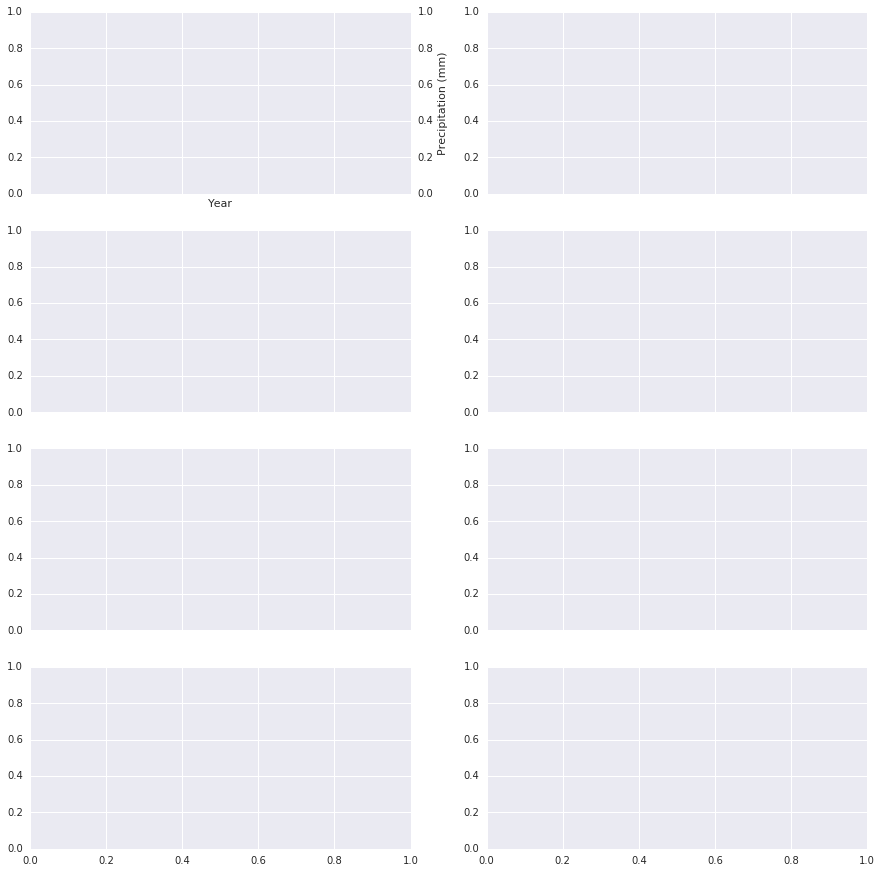

In [14]:
print(df_net.columns)
df_avg = df_prcp_re.mean()
# print(df_avg)
# df_avg = pd.concat([df_avg]*12)#, ignore_index=True)
# df_avg.columns = df_prcp_re.columns
# df_avg.index = df_prcp_re.index
# print(df_avg[0])
fig, rows = plt.subplots(4, 2, figsize=(15, 15), sharex=True)
idx = 1
width = 0.3
y1 = [0, 7, 8, 15, 30, 32, 48, 55, 60]
y2 = [0, 12, 12, 30, 40, 50, 52, 60, 70]
y3 = [0, 0, 100, 300, 700, 1000, 1300, 1600, 1600]
y4 = [0, 10, 140, 600, 900, 1400, 1600, 1800, 2000]

for row in rows:
    for ax in row:
        ax1 = ax.twinx()
        ax.set_xlabel("Year")        
        ax1.set_ylabel("Net Cropland Area (mha)")
        ax1.set_ylabel("Precipitation (mm)")        
        title = 'AEZ %d' % idx                
        df_prcp_re.plot(color='b', y=title, ax=ax1, secondary_y=True, kind='bar', legend=False, title=title, ylim=[y3[idx], y4[idx]])#, kind='bar', width=width, position=1, ylim=(y3[idx], y4[idx]))
#         df_net.plot(color='r', y=title, ax=ax, legend=False)
#         ax = df_prcp_re.plot(y=title, kind="bar"); plt.xticks(rotation=0)
        ax1.plot(ax.get_xticks(), df_net[title])
        
        
#         print(df_prcp_re[title].mean())
#         df_avg = pd.DataFrame([df_prcp_re[title].mean() for i in range(12)], index=df_prcp_re.index)        
#         df_avg.plot(color='r', ax=ax, secondary_y=True, legend=False)
        
#         ticklabels = ['']*len(df_prcp_re.index)
#         ticklabels[::1] = [item.strftime('%Y') for item in df_prcp_re.index[::1]]
#         ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        idx += 1
plt.gcf().autofmt_xdate()

## get annual fallow from GCPA

In [ ]:
mha = ee.Image.pixelArea().multiply(1e-10)
def fetch_band(img):
    img = ee.Image(img)
    mask = img.eq(9)
    return mask.select([0], ['crop']).multiply(mha)

bandlist = ee.ImageCollection('users/JunXiong1981/GCPA250mv3').sort('index', True).toList(12).map(fetch_band)
bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
rd = bands.reduceRegions(continent, ee.Reducer.sum(), 2330)
date = ['%d0101' % d for d in range(2003, 2015)]
df_fa = gets(rd, 'crop', date=date) * 0.28
df_fa.plot(title='annual fallow from GCPA')

In [ ]:
# get annual cropland from GCPA
mha = ee.Image.pixelArea().multiply(1e-10)
def fetch_band(img):
    img = ee.Image(img)
    mask = img.gt(0).And(img.lt(10))
    return mask.select([0], ['crop']).multiply(mha)

bandlist = ee.ImageCollection('users/JunXiong1981/GCPA250mv3').sort('index', True).toList(12).map(fetch_band)
bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
rd = bands.reduceRegions(continent, ee.Reducer.sum(), 2330)
date = ['%d0101' % d for d in range(2003, 2015)]
df_net = gets(rd, 'crop', date=date) 
df_net.plot(title='annual cropland from GCPA')

In [ ]:
mha = ee.Image.pixelArea().multiply(1e-10)
def fetch_band(img):
    img = ee.Image(img)    
    mask = img.gt(0).And(img.lt(15))
    return mask.select([0]).multiply(mha)

bandlist = ee.ImageCollection('users/JunXiong1981/GCPA/GCPA250m').sort('index', True).toList(12).map(fetch_band)
bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
date = ['%d0101' % d for d in range(2003, 2015)]
print(date)
rd = bands.reduceRegions(regions, ee.Reducer.sum(), 2.5e6)
df = gets(rd, 'b1', date=date)
df.plot()


In [ ]:
# snippet to calculate total area for entire Africa
mha = ee.Image.pixelArea().multiply(1e-10)
countries = ee.FeatureCollection('ft:1fGODObRcgWotUauiKV_2GlM7ZXX0sdZ5FLTJeALZ') # Countries
features = mha.reduceRegions(countries, ee.Reducer.sum(), 250).getInfo()['features']
index = [feature['properties']['country'] for feature in features]
value = [feature['properties']['sum'] for feature in features]
df = pd.DataFrame(value, index=index)
df = df.sort_index()
df.to_csv('tota_country.csv')

In [ ]:
print(df.index)

In [ ]:
def gd_chirp_data(start='2003-01-01', end='2015-12-31', nbands=72*13): 
    collection = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') # 5 day chirp rainfall data    
    bandlist = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation') \
    .filterDate(start, end).sort('system:index', True) \
    .toList(nbands).map(rename_bands)
    
    bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
    regions = ee.FeatureCollection('ft:1fM786Wbri6CqIz3JvyQ_vvMIBGbdUmTOGacZTnb-')
    info = bands.reduceRegions(regions, ee.Reducer.mean(), 50000).getInfo()
#     columns = []    
    for feature in info['features']:        
        df = feature['properties']
#         print(df)
        row = [[df[k]] for k in sorted(df.keys()) if k.endswith('precipitation')]                
#         print(row)
        try:
            void = value.shape
        except:            
            value = numpy.empty((len(row), 0))                        
            date = pd.to_datetime([k.split('_')[0] for k in sorted(df.keys()) if k.endswith('precipitation')], 
                                   format="%Y%m%d")
        value = numpy.concatenate((value, numpy.array(row)), axis=1)        
#         columns.append('Region %d' % df['region'])    
    ret = pd.DataFrame(value, index=date)
    ret.columns = ['Africa']
    return ret
df = load_dataset('chirp_data_stat_afr', gd_chirp_data, True)
# print(df)

In [ ]:
def gd_chirp_data(start='2003-01-01', end='2015-12-31', nbands=72*13): 
    collection = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') # 5 day chirp rainfall data    
    bandlist = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation') \
    .filterDate(start, end).sort('system:index', True) \
    .toList(nbands).map(rename_bands)
    
    bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
    regions = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt')
    info = bands.reduceRegions(regions, ee.Reducer.mean(), 50000).getInfo()
    columns = []    
    for feature in info['features']:        
        df = feature['properties']
        row = [[df[k]] for k in sorted(df.keys()) if k.endswith('precipitation')]                
        try:
            void = value.shape
        except:            
            value = np.empty((len(row), 0))                        
            date = pd.to_datetime([k.split('_')[0] for k in sorted(df.keys()) if k.endswith('precipitation')], 
                                   format="%Y%m%d")
        value = np.concatenate((value, np.array(row)), axis=1)        
        columns.append('Region %d' % df['region'])    
    ret = pd.DataFrame(value, index=date)
    ret.columns = columns
    return ret

def df_ts_test(start='2003-01-01', end='2015-12-31', nbands=23*13):        
    bandlist = ee.ImageCollection('MODIS/MYD13Q1').select('NDVI') \
    .filterDate(start, end).sort('system:index', True) \
    .toList(nbands).map(rename_bands)
    bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))
    region = ee.Geometry.Polygon(
            [[[-116.455078125, 38.66721265734852],
              [-116.279296875, 37.76955709975364],
              [-113.466796875, 37.908378154711016],
              [-113.90625, 39.00950955260123]]])    
    info = bands.reduceRegion(ee.Reducer.mean(), region, 5000).getInfo()
    value = [info[k] for k in sorted(info.keys()) if k.startswith('MYD13Q1')]
    date = pd.to_datetime([k.lstrip('MYD13Q1_005_').rstrip('_NDVI') for k in sorted(info.keys()) if k.startswith('MYD13Q1')],
                          format="%Y_%m_%d")             
    ret = pd.DataFrame(value, index=date)       
    ret.columns = ['df_ts_test']
    return ret

def gd_16day_ndvi(start='2003-01-01', end='2015-12-31', nbands=23*13):     
    bandlist = ee.ImageCollection('MODIS/MYD13Q1').select('NDVI') \
    .filterDate(start, end).sort('system:index', True) \
    .toList(nbands).map(rename_bands)
    bands = ee.Image(bandlist.slice(1).iterate(stack_bands, bandlist.get(0)))

    regions = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt')
    info = bands.reduceRegions(regions, ee.Reducer.mean(), 50000).getInfo()       
    columns = []
    for feature in info['features']:
        df = feature['properties']
        row = [[df[k]] for k in sorted(df.keys()) if k.startswith('MYD13Q1')]
        try:
            void = value.shape
        except:            
            value = np.empty((len(row), 0))
            date = pd.to_datetime([k.lstrip('MYD13Q1_005_').rstrip('_NDVI') for k in sorted(df.keys()) if k.startswith('MYD13Q1')],
                          format="%Y_%m_%d")
        value = np.concatenate((value, np.array(row)), axis=1)
        columns.append('Region %d' % df['region'])    
    ret = pd.DataFrame(value, index=date)       
    ret.columns = columns
    return ret
# df = load_dataset('ts-test', df_ts_test)#, True)
# df.plot()

# df = load_dataset('16day_ndvi', gd_16day_ndvi)#, True)
# df = df.resample('A', how=sum) / 23 / 1e4
# df.columns.name = 'NDVI'
# df.index.name = 'Year'
# df.plot(title='Title')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
# df.to_csv('yearly_ndvi_AEZ.csv')

# df = load_dataset('chirp_rainfall_AEZ', gd_chirp_data, True)
# df = df.resample('A', how=sum) 
# df.columns.name = 'Precipitation (mm)'
# df.index.name = 'Year'
# df.plot(title='precipitation')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# # df.to_csv('yearly_ndvi_AEZ.csv')


In [ ]:
def gd_16day_ndvi(start='2003-01-01', end='2015-12-31', nbands=23*13):     
    ce = ee.Image("users/JunXiong1981/accaafrica2502014l1-extendv23");
    mask = ce.gt(0).And(ce.lt(3))
    bandlist = ee.ImageCollection('MODIS/MYD13Q1').select('NDVI') \
    .filterDate(start, end).sort('system:index', True) \
    .toList(nbands).map(rename_bands)
    bands = ee.Image(bandlist.slice(1).iterate(bandStack, bandlist.get(0)))

    regions = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt')
    info = bands.updateMask(mask).reduceRegions(regions, ee.Reducer.mean(), 50000).getInfo()       
    columns = []
    for feature in info['features']:
        df = feature['properties']
        row = [[df[k]] for k in sorted(df.keys()) if k.startswith('MYD13Q1')]
        try:
            void = value.shape
        except:            
            value = numpy.empty((len(row), 0))
            date = pd.to_datetime([k.lstrip('MYD13Q1_005_').rstrip('_NDVI') for k in sorted(df.keys()) if k.startswith('MYD13Q1')],
                          format="%Y_%m_%d")
        value = numpy.concatenate((value, numpy.array(row)), axis=1)
        columns.append('Region %d' % df['region'])    
    ret = pd.DataFrame(value, index=date)       
    ret.columns = columns
    return ret
df = load_dataset('16day_crop_ndvi_AEZ', gd_16day_ndvi, True)


In [ ]:
df = load_dataset('16day_crop_ndvi_AEZ', gd_16day_ndvi)#, True)
df1 = load_dataset('16day_ndvi', gd_16day_ndvi)#, True)
df = df.resample('A', how=sum) / 23 / 1e4 * 82.07
df1 = df1.resample('A', how=sum) / 23 / 1e4 * 82.07
df = df.sum(axis=1)
df1 = df1.sum(axis=1)
df.plot(legend=False)
df1.plot(legend=False)
# print(df)
# print(df1)

In [ ]:
rf = load_dataset('chirp_data_stat_afr', dummy)#, True)
rf = rf.resample('A', how=sum) 
rf.columns = ['CHIRPS']
df = pd.read_csv('old-stat.csv', index_col=[0], parse_dates=True)

fig, ax = plt.subplots(figsize=(10,8))

ax.set_ylabel('Annual preciptation (mm)')
df.plot(color='r', y='TRMM', ax=ax)
# df.plot(color='r', y=col, ax=ax, legend=False)        
rf.plot(color='b', ax=ax)#, ax=ax, legend=False)

In [ ]:
dummy = lambda a: None
from matplotlib import dates
import matplotlib.ticker as ticker
# 2y-axis plot, compare NDVI and precipitation
df = load_dataset('ce-cropland-stat', dummy)#, True)
df = df.resample('A', how=sum) / 23 / 1e4 * 82.07
df1 = load_dataset('chirp_rainfall_AEZ', dummy)#, True)
df1 = df1.resample('A', how=sum) 

fig, rows = plt.subplots(4, 2, figsize=(15, 15), sharex=True)
# plt.subplots_adjust(wspace = 0.4)
idx = 1
width = 0.3
y1 = [0, 7, 8, 15, 30, 32, 48, 55, 60]
y2 = [0, 12, 12, 30, 40, 50, 52, 60, 70]
y3 = [0, 0, 100, 300, 700, 1000, 1300, 1600, 1600]
y4 = [0, 10, 140, 600, 900, 1400, 1600, 1800, 2000]

for row in rows:
    for ax in row:
        ax.set_xlabel("Year")
        ax.set_ylabel("Net Cropland (Mha)")
        ax1 = ax.twinx()        
        ax1.set_ylabel("Precipitation (mm)")
        col = 'Region %d' % idx
        title = 'AEZ %d' % idx
        df.plot(color='r', y=col, ax=ax, legend=False, title=title,ylim=(y1[idx], y2[idx]))        
        df1.plot(color='b', y=col, ax=ax1, secondary_y=True, legend=False, kind='bar', width=width, position=1, ylim=(y3[idx], y4[idx]))
#         df1.plot(color='b', y=col, ax=ax1, secondary_y=True, legend=False, kind='bar', width=width, position=0)#, ylim=(0, 100))
#         ax.set_ylim((0,100))
        ax1.set_ylim((y3[idx], y4[idx]))
        ticklabels = ['']*len(df.index)
        ticklabels[::1] = [item.strftime('%Y') for item in df.index[::1]]
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax1.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc=0)
        
#         df.plot(color='r', y=col, ax=ax, legend=False, title=col)        
#         df1.plot(color='b', y=col, ax=ax1, secondary_y=True, legend=False)
#         ax.xaxis.set_major_locator(dates.YearLocator())
#         ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        idx += 1
plt.gcf().autofmt_xdate()

In [ ]:
dummy = lambda a: None
from matplotlib import dates
# 2y-axis plot, compare NDVI and precipitation
df = load_dataset('ce-cropland-stat', dummy)#, True)
df = df.resample('A', how=sum) / 23 / 1e4 * 82.07
df1 = load_dataset('chirp_rainfall_AEZ', dummy)#, True)
df1 = df1.resample('A', how=sum) 
print(df)
print(df1)

In [ ]:
# 2y-axis plot, compare NDVI and precipitation
df = load_dataset('ce-cropland-stat', dummy)#, True)
df = df.resample('A', how=sum) / 23 / 1e4 * 82.07
df.to_csv('year_cropland_area')
        
df1 = load_dataset('chirp_rainfall_AEZ', dummy)#, True)
df1 = df1.resample('A', how=sum) 

fig, rows = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = 0.3)
idx = 1
width = 0.4
y1 = [0, 7, 8, 15, 30, 32, 50, 55, 60]
y2 = [0, 9, 12, 30, 40, 50, 60, 60, 70]
y3 = [0, 5, 100, 300, 700, 1000, 1300, 1600, 1600]
y4 = [0, 6, 140, 600, 900, 1400, 1600, 1800, 2000]
for row in rows:
    for ax in row:
        col = 'Region %d' % idx
        ddf = pd.concat([df[col],df1[col]], axis=1) # add row
        ddf.columns = ['NCA', 'Prcp']        
        ddf.plot(kind='scatter', x='NCA', y='Prcp', ax=ax, title=col)
        ax.set_xlabel("Net Cropland Area (Mha)")
        ax.set_ylabel("Annual Precipitation (mm)")        
        idx += 1

In [ ]:
# collect cropland area from GEE
gcpa = ee.Image('users/JunXiong1981/accaafrica2502014l4-dominancev3').remap([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,1,1,1,1,0])
# mask = gcpa.gte(1).And(gcpa.lt(9))
# gcpa = gcpa.mask(mask)
ha = ee.Image.pixelArea().multiply(1e-10)
regions = ee.FeatureCollection('ft:19hZjN8dbwPbDHNdLVaoGLEtmIbxAtrn4yDr9QVgt') # AEZ 8
# regions = ee.FeatureCollection('ft:1fGODObRcgWotUauiKV_2GlM7ZXX0sdZ5FLTJeALZ') # Country 55
info = ha.multiply(gcpa).reduceRegions(regions, ee.Reducer.sum(), 233).getInfo()
value = []
ind = []
for feature in info['features']: # read from featureCollection
    df = feature['properties']
    print(df['region'])
    ind.append(df['region'])
    value.append(df['sum'])    
ret = pd.DataFrame(value, index=ind)
ret.plot()
print(ret.to_string(index=False))

In [ ]:
# extract the header column names
header = info[0]
# create a Numpy array of the data
data = array(info[1:])

Next we extract time information and convert it to at Python datatime data type.

In [ ]:
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

Extract the data columns what we want to display on the plot.

In [ ]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)

Calculate NDVI

In [ ]:
band3 = yData[:,2]
band4 = yData[:,3]
ndvi = (band4 - band3) / (band4 + band3)

And finally, we create a plot of MODIS band values as a function of time.

In [ ]:
# matplotlib date format object

fig = figure(figsize=(12,8), dpi=80)

# plot the band values
ax1 = fig.add_subplot(211)
ax1.plot(time, yData[:,2], 'o', color="red", label="Band 3")
ax1.plot(time, yData[:,3], 'o', color="magenta",  label="Band 4")
ax1.legend(loc='best')
ax1.grid(True)

#plt.title('Band values as a function of time')
ax1.set_ylabel('Band Values')

# plot NDVI
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(time, ndvi, 'o', color="black", label="NDVI")
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)